**Импорт библиотек и выбор параметров сигнала**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import load_model
import tensorflow as tf
import numpy as np
import tensorflow.keras.layers as layers
import keras
from matplotlib.ticker import (AutoMinorLocator)

# Настройка представления
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

A = 10
N = 256
f1 = 10
f2 = 21
f3 = 18
f4 = 23
f5 = 16
num_period = 0.5

2024-12-04 02:00:11.026548: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733266812.141136   74415 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733266812.380354   74415 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-04 02:00:14.003255: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


**Построение графика сигнала**

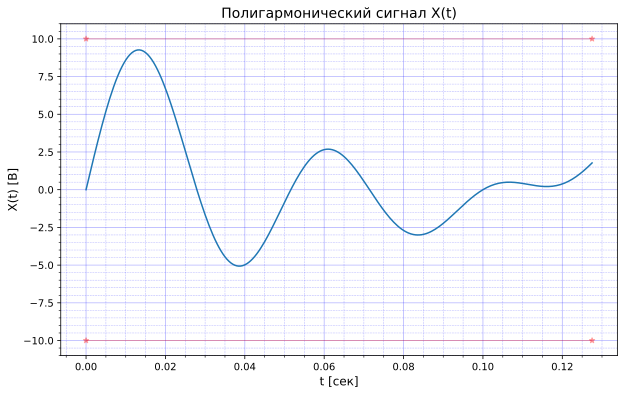

In [2]:


i = np.arange(N) # Массив номеров отсчетов 1..N
f = np.array([f1, f2, f3, f4, f5]) # Массив частот составляющих полигармонического сигнала

T = 1/min(f) * 0.01 * num_period# Период дискретизации сигнала

X = 0
for k in np.arange(f.size):
  X += np.sin(2*np.pi*f[k]*T*i)
X *= A/f.size # Приводим сигнал к заданной амплитуде

fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
ax.set_title('Полигармонический сигнал X(t)', fontsize=14)
ax.set_xlabel('t [сек]', fontsize=12)
ax.set_ylabel('X(t) [В]', fontsize=12)
ax.plot(i*T, X)
ax.plot([i[0]*T, i[-1]*T], [A, A], 'r-*', linewidth=1, alpha=0.3)
ax.plot([i[0]*T, i[-1]*T], [-A, -A], 'r-*', linewidth=1, alpha=0.3)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.grid(which='major', color='blue', linewidth=0.75, alpha=0.3)
ax.grid(which='minor', linestyle='--', color='blue', linewidth=0.5, alpha=0.3)

**Наложение шума на сигнал**

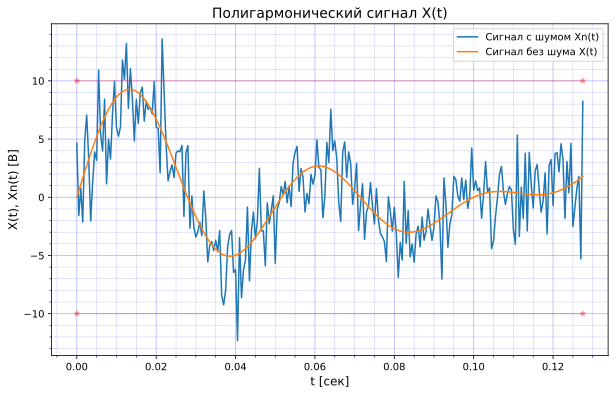

In [3]:
noise_level = 0.25
rng = np.random.default_rng(12340)
noise = rng.normal(0, A*noise_level, N)

# Накладываем шум на полезный сигнал и строим график
Xn = X + noise
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
ax.set_title('Полигармонический сигнал X(t)', fontsize=14)
ax.set_xlabel('t [сек]', fontsize=12)
ax.set_ylabel('X(t), Xn(t) [В]', fontsize=12)
ax.plot(i*T, Xn, label='Сигнал c шумом Xn(t)')
ax.plot(i*T, X, label='Сигнал без шума X(t)')
ax.plot([i[0]*T, i[-1]*T], [A, A], 'r-*', linewidth=1, alpha=0.3)
ax.plot([i[0]*T, i[-1]*T], [-A, -A], 'r-*', linewidth=1, alpha=0.3)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.grid(which='major', color='blue', linewidth=0.75, alpha=0.3)
ax.grid(which='minor', linestyle='--', color='blue', linewidth=0.5, alpha=0.3)
ax.legend()



**Переход в спектральную область**

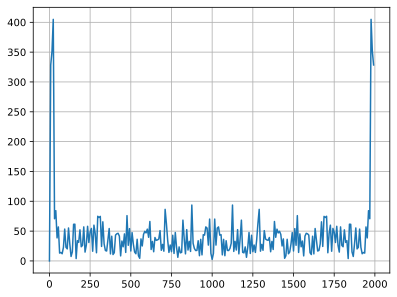

In [4]:
cn_mean = np.mean(Xn) # Запоминаем (понадобится при восстановлении сигнала)
Xn = Xn - cn_mean
# Преобразование Фурье (прямое)

Xf=np.fft.fft(Xn)/len(Xn)
Xf=np.fft.fftn(Xn)
# Амплитудный спектр
Af=np.abs(Xf)
# Разрешение по частоте
b=1/(N*T)
# Массив частот
Ff=np.arange(N)*b

plt.plot(Ff, Af)
plt.grid(True)

**Подбор порога фильтрации**

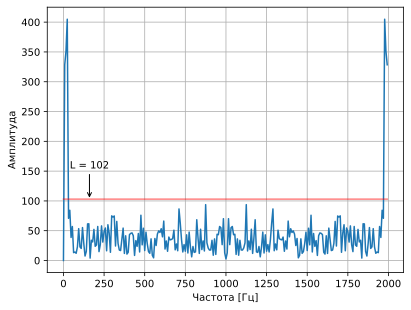

In [ ]:
Xf=np.fft.fft(Xn)/len(Xn)
Xf=np.fft.fftn(Xn)
# Амплитудный спектр
Af=np.abs(Xf)
L= np.max(Af[Af < np.max(Af)/2]) * 0.9

annotation = 'L = '+str(int(L))

fig, ax = plt.subplots()
ax.plot(Ff, Af)
ax.plot([Ff[0], Ff[-1]], [L, L], 'r-', alpha=0.5)
 
ax.annotate(annotation, xy=(f[f.size-1]*10, int(L)), xytext=(f[f.size-1]*10, (L*1.5)), 
            ha='center', arrowprops={'arrowstyle':'->'})
ax.set_xlabel("Частота [Гц]")
ax.set_ylabel("Амплитуда")
plt.grid(True)
plt.show()

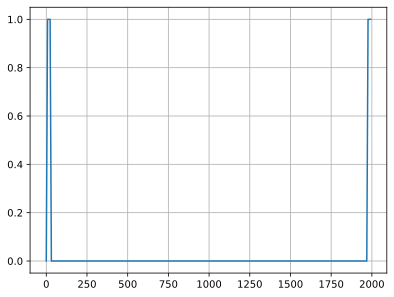

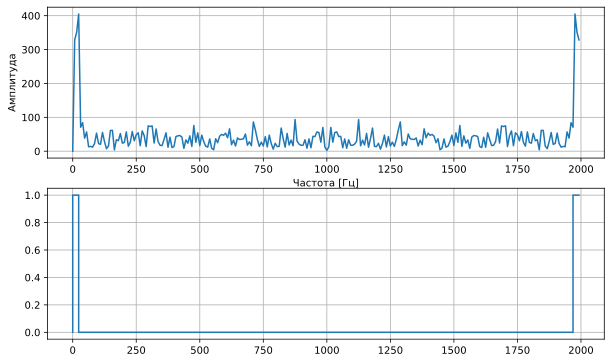

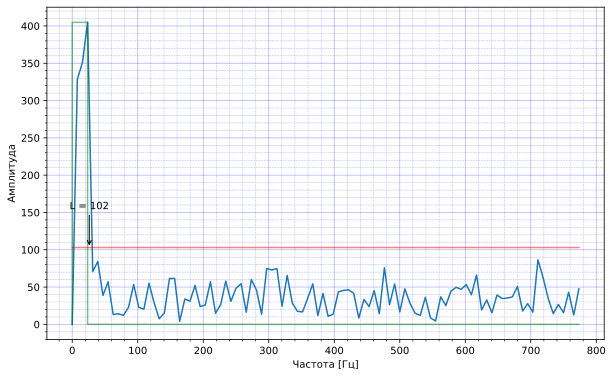

In [12]:
Wf = np.where(Af>L,1,0)
plt.plot(Ff, Wf)
plt.grid(True)

plt.figure(figsize=(10, 6), dpi=300)
# Амплитудный спектр
plt.subplot(2,1,1)
plt.plot(Ff, Af)
plt.grid(True)
plt.xlabel("Частота [Гц]")
plt.ylabel("Амплитуда")
# Окно фильтра
plt.subplot(2,1,2)
plt.step(Ff, Wf)
plt.grid(True)


Np = 100
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
ax.plot(Ff[:Np], Af[:Np])
ax.plot([Ff[0], Ff[Np-1]], [L, L], 'r-', alpha=0.5)
ax.step(Ff[:Np], Wf[:Np]*Af.max(), 'g-', alpha=0.5)
ax.set_xlabel("Частота [Гц]")
ax.set_ylabel("Амплитуда")
 
ax.annotate(annotation, xy=(f[f.size-1]+f[0], L), xytext=(f[f.size-1]+f[0], L*1.5), 
            ha='center', arrowprops={'arrowstyle':'->'})
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.grid(which='major', color='blue', linewidth=0.75, alpha=0.3)
ax.grid(which='minor', linestyle='--', color='blue', linewidth=0.5, alpha=0.3)
ax.set_xlabel("Частота [Гц]")
ax.set_ylabel("Амплитуда")
plt.grid(True)
plt.show()

**Обратный переход во временную область**

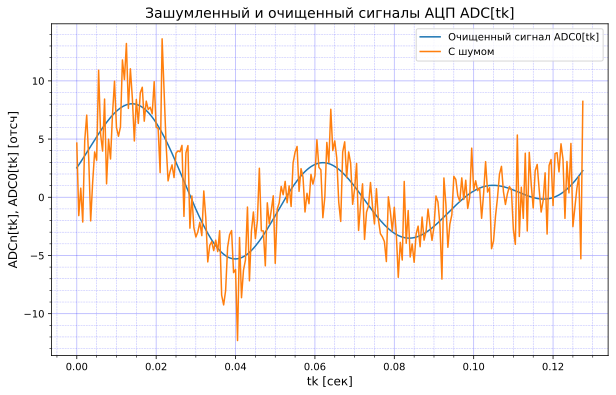

In [14]:
Xf0=Xf*Wf # Накладываем окно на спектр сигнала
# Выполняем обратное преобразование
# и оставляем только действительную часть
c0=np.real(np.fft.ifft(Xf0))/T
c0=np.real(np.fft.ifftn(Xf0))
# Восстанавливаем сигналы с учетом постоянной составляющей
c0 = c0 + cn_mean
cn = Xn + cn_mean
# Визуализация
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
ax.set_title('Зашумленный и очищенный сигналы АЦП ADC[tk]', fontsize=14)
ax.set_xlabel('tk [сек]', fontsize=12)
ax.set_ylabel('ADCn[tk], ADC0[tk] [отсч]', fontsize=12)
ax.plot(i*T, c0, label='Очищенный сигнал ADC0[tk]')
ax.plot(i*T, cn, label='С шумом')
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.grid(which='major', color='blue', linewidth=0.75, alpha=0.3)
ax.grid(which='minor', linestyle='--', color='blue', linewidth=0.5, alpha=0.3)
ax.legend()

***Сравнение результатов работы фильтра низких частот и вывода модели**

In [77]:

def generate_impulse_noise(length, frequency):
    A_d = (5, 20)
    noise = np.zeros(length)
    
    num_impulses = int(length * frequency)
    
    # Генерируем случайные индексы для импульсов
    impulse_indices = np.random.randint(0, length, num_impulses)
    
    amplitudes = np.random.uniform(A_d[0], A_d[1], num_impulses) 
    
    # Добавляем импульсы в массив шума
    noise[impulse_indices] = amplitudes
    
    return noise

def get_signal(N):
    A_d = (5, 40)
    f_d = (10, 300)
    step_d = (10, 80)
    noise_d= (0.1, 0.15)
    frequency = 0.01
    T = 0.001
    noise_factor = np.random.uniform(noise_d[0], noise_d[1])
    
    A = np.random.uniform(A_d[0],A_d[1])
    start_f = np.random.randint(f_d[0], f_d[1])
    step = np.random.randint(step_d[0], step_d[1])
    f = np.array([start_f, start_f+step, start_f+2*step, start_f+3*step, start_f+4*step]) 

    i = np.arange(N)
  
    X = 0
    for k in np.arange(f.size):
        X += np.sin(2*np.pi*f[k]*T*i)
    X *= A/f.size
    
    noise = np.random.normal(0, A*noise_factor, N)
    X_noise = X + noise
    if np.random.randint(0, 3) == 0:
        g = generate_impulse_noise(N, frequency)
        X_noise += g
    return X, X_noise
    
    

def arith_mean(f, buffer_size=10):
    # Creating buffer
    if not hasattr(arith_mean, "buffer"):
        arith_mean.buffer = [f] * buffer_size

    # Move buffer to actually values ( [0, 1, 2, 3] -> [1, 2, 3, 4] )
    arith_mean.buffer = arith_mean.buffer[1:]
    arith_mean.buffer.append(f)

    # Calculation arithmetic mean
    mean = 0
    for e in arith_mean.buffer: mean += e
    mean /= len(arith_mean.buffer)

    return mean

def viner(data):
    dNoise = 0.25     # дисперсия шума
    a = 0.9        # корреляция между соседними отсчетами

    ex = np.var(data) # дисперсия сигнала (относительно нуля)


    #формируем вспомогательные матрицы
    R = np.array([[a**np.abs(i-j) for j in range(N)] for i in range(N)])
    V = np.eye(N)*dNoise
    RVinv = np.linalg.inv(R+V/ex)

    # построение оценок
    mz = data.mean() # среднее значение наблюдений
    xx = np.zeros(N)
    for k in range(N):
        alfa = np.dot(R[:, k], RVinv)
        xx[k] = np.dot(alfa, (data-mz)) + mz
    return xx

def exponential_moving_avereage(data, smooth_interval = 2):
    if smooth_interval >= len(data):
        print("Smooth interval more or equal array lenght!")
        return
    
    alpha = 2.0/(smooth_interval+1)
    filtered_values = np.zeros(len(data))
    sum = 0

    for step in range(smooth_interval):
        sum += data[step]
    previous_ma_value = sum/smooth_interval

    for step in range(smooth_interval-1):
        previous_ma_value = alpha*data[step]+(1-alpha)*previous_ma_value
        filtered_values[step] = previous_ma_value

    sum = 0

    for step in range(smooth_interval):
        sum += data[step]
    previous_ma_value = sum/smooth_interval
    filtered_values[smooth_interval-1] = previous_ma_value

    for step in range(smooth_interval, len(data)):
        previous_ma_value = alpha*data[step]+(1-alpha)*previous_ma_value
        filtered_values[step] = previous_ma_value

    return filtered_values



def low_freq(data):
    from scipy import signal
    from scipy.signal import butter, filtfilt
    order = 6
    Xf=np.fft.fft(data)/len(data)
    Xf=np.fft.fftn(data)
    # Амплитудный спектр
    Af=np.abs(Xf)
    L= np.max(Af[Af < np.max(Af)/2]) * 0.9
    print("L", L)
    nyquist_freq = 5 * N 
    print("L/nyquist_freq", L, L/nyquist_freq)
    b, a = butter(order, L/nyquist_freq, btype='low')

    return filtfilt(b, a, data)

def network_predict(data):
    model = load_model('mdl_start_new.keras')
    data_min = np.min(data)
    data_max = np.max(data)
    noisy_sample = np.array((data - data_min) / (data_max  - data_min))

    reconstruction = model.predict(np.array(noisy_sample).reshape(1, 256,1)).reshape(256,1)
    
    denorm_result = reconstruction * (data_max - data_min) + data_min
    
    return denorm_result

def get_memory_usage(func, data):
    import psutil
    import os
    import tracemalloc
    tracemalloc.start()
    start_memory = tracemalloc.get_traced_memory()[1]
    
    result = func(data)
    
    current_memory = tracemalloc.get_traced_memory()[1]
    tracemalloc.stop()
    
    memory_used = (current_memory - start_memory) / 1024 / 1024  # Конвертация в МБ
    return result, np.round(memory_used, decimals=4)

def create_custom_heatmap(data, ax, title):
    # Получаем среднее и максимальное значение
    mean_val = np.mean(data.values)
    max_val = np.max(data.values)
    
    # Создаем маску для значений ниже среднего
    mask_below_mean = data < mean_val
    mask_above_mean = data >= mean_val
    
    # Создаем два разных heatmap'а
    # Для значений ниже среднего (зеленые оттенки)
    sns.heatmap(data, mask=~mask_below_mean, 
                cmap='Greens', 
                annot=True, fmt='.4f',
                ax=ax, 
                cbar=False)
    
    # Для значений выше среднего (красные оттенки)
    g = sns.heatmap(data, mask=~mask_above_mean,
                cmap='YlOrRd',
                annot=True, fmt='.4f',
                ax=ax,
                cbar=True)
    
    ax.set_title(f'{title}\nMean value: {mean_val:.4f}')
    ax.set_xlabel('Filters')
    ax.set_ylabel('Generation')
    plt.tight_layout()
    plt.show()
    g.figure.savefig("output.png")

    

L 105.89126084868097
L/nyquist_freq 105.89126084868097 0.082727547538032
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step
L 189.14986313604447
L/nyquist_freq 189.14986313604447 0.14777333057503475
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
L 146.9481796371415
L/nyquist_freq 146.9481796371415 0.11480326534151679
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 825ms/step
L 350.99343668043
L/nyquist_freq 350.99343668043 0.274213622406586
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
L 336.3814343895273
L/nyquist_freq 336.3814343895273 0.2627979956168182
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step
L 242.4666787742159
L/nyquist_freq 242.4666787742159 0.18942709279235617
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step
L 200.83749172855488
L/nyquist_freq 200.83749172855488 0.1569042904129335
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step
dict_keys(['low_freq', 'network_predict', 'exp_moving_avg', 'arith_mean', 'viner'])


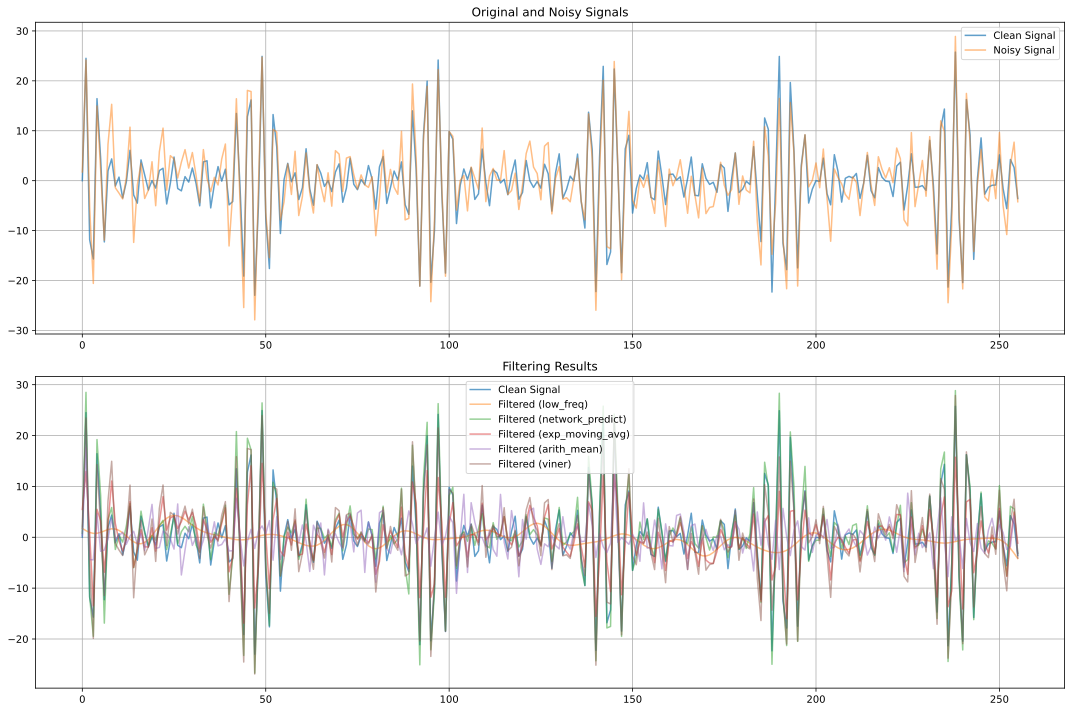

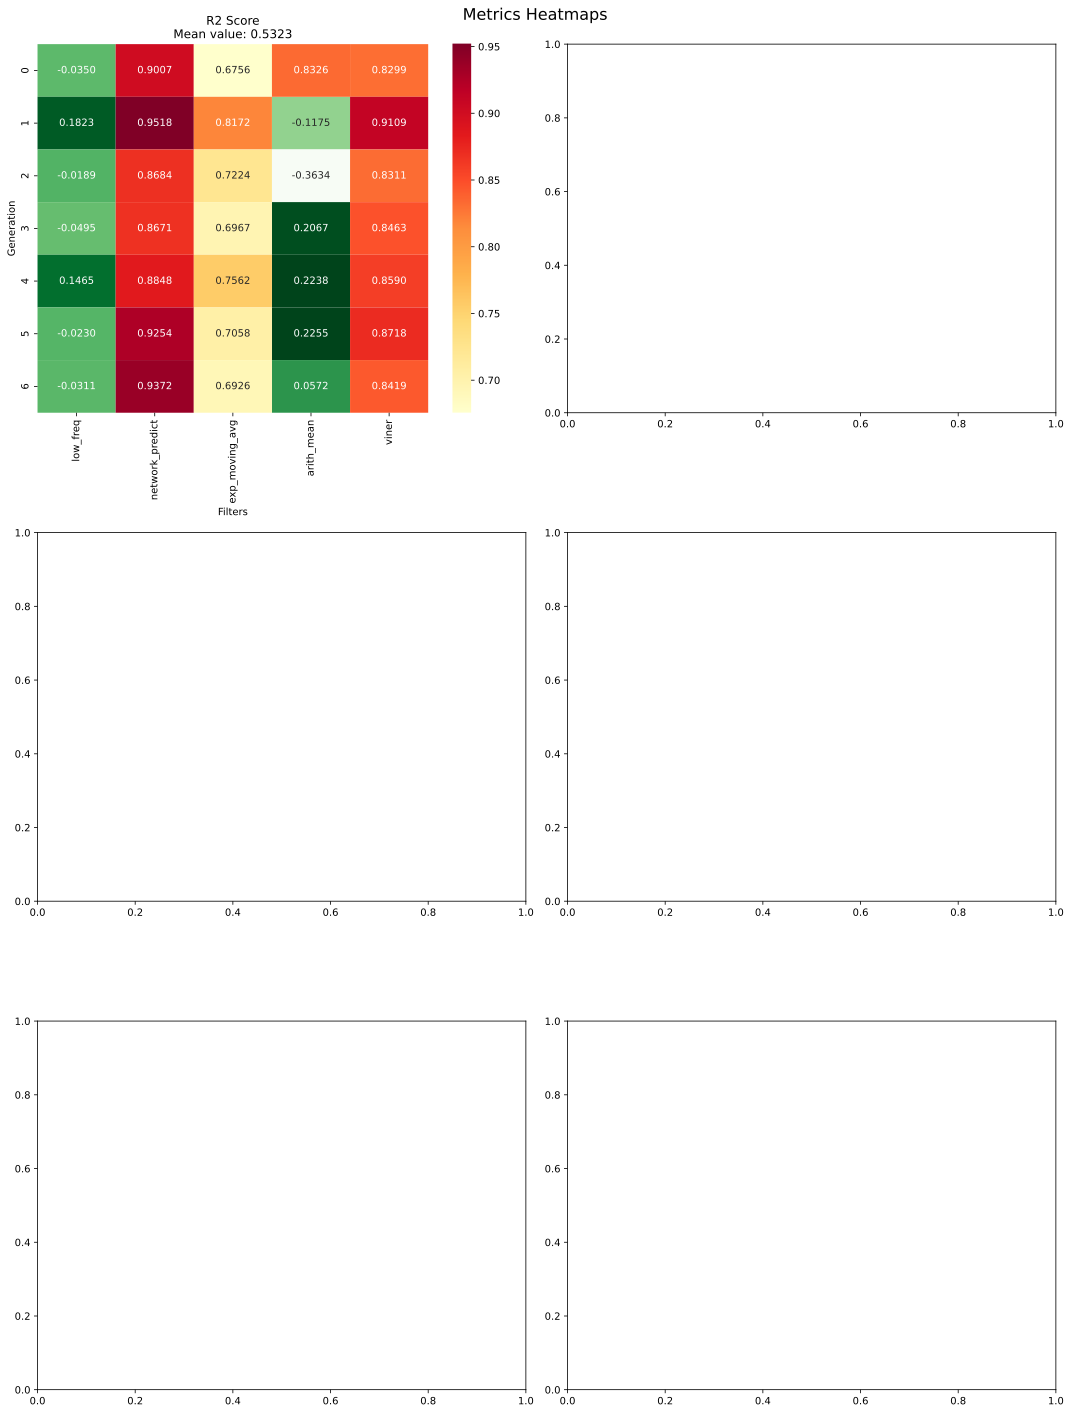

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

R2 Scores:
   generation  low_freq  network_predict  exp_moving_avg  arith_mean   viner
0           1   -0.0350           0.9007          0.6756      0.8326  0.8299
1           2    0.1823           0.9518          0.8172     -0.1175  0.9109
2           3   -0.0189           0.8684          0.7224     -0.3634  0.8311
3           4   -0.0495           0.8671          0.6967      0.2067  0.8463
4           5    0.1465           0.8848          0.7562      0.2238  0.8590
5           6   -0.0230           0.9254          0.7058      0.2255  0.8718
6           7   -0.0311           0.9372          0.6926      0.0572  0.8419

MAE Scores:
   generation  low_freq  network_predict  exp_moving_avg  arith_mean   viner
0           1    2.5293           0.9151          1.5590      1.1831  1.2010
1           2    3.4239           0.9537          1.7620      4.3186  1.3086
2           3    2.8447           1.0432          1.5336      3.5552  1.1738
3           4    7.6817           3.0905          4.

In [78]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import time
import seaborn as sns

N = 256

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

def create_metrics_table(signals_count=5):
    # Создаем словари для хранения результатов
    r2_results = {'generation': []}
    mae_results = {'generation': []}
    mse_results = {'generation': []}
    time_results = {'generation': []}
    memory_results = {'generation': []}
    
    # Названия фильтров
    filters = {
        'low_freq': low_freq,
        'network_predict': network_predict,
        'exp_moving_avg': lambda x: exponential_moving_avereage(x, 2),
        'arith_mean': lambda x: arith_mean(x, 8),
        'viner': viner
    }
    
    # Инициализируем колонки для каждого фильтра
    for filter_name in filters.keys():
        r2_results[filter_name] = []
        mae_results[filter_name] = []
        mse_results[filter_name] = []
        time_results[filter_name] = []
        memory_results[filter_name] = []

    last_signals = {}
    # Генерируем сигналы и применяем фильтры
    for i in range(signals_count):
        clean_signal, noisy_signal = get_signal(N)  # предполагаем, что длина сигнала 1000
        r2_results['generation'].append(i+1)
        mae_results['generation'].append(i+1)
        mse_results['generation'].append(i+1)
        time_results['generation'].append(i+1)
        memory_results['generation'].append(i+1)
        
        if i == signals_count - 1:
            last_signals['clean'] = clean_signal
            last_signals['noisy'] = noisy_signal     

                   
        # Применяем каждый фильтр
        for filter_name, filter_func in filters.items():
            # Замеряем время выполнения
            start_time = time.time()
            filtered_signal, memory_used = get_memory_usage(filter_func, noisy_signal)
            end_time = time.time()
            
            if i == signals_count - 1:
                last_signals[filter_name] = filtered_signal

            
            # Вычисляем метрики
            r2 = r2_score(clean_signal, filtered_signal)
            mae = mean_absolute_error(clean_signal, filtered_signal)
            mse = mean_squared_error(clean_signal, filtered_signal)

            r2 = np.round(r2_score(clean_signal, filtered_signal), decimals=4)
            mae = np.round(mean_absolute_error(clean_signal, filtered_signal), decimals=4)
            mse = np.round(mean_squared_error(clean_signal, filtered_signal), decimals=4)
            exec_time = np.round(end_time - start_time, decimals=4)
                        
            # Сохраняем результаты
            r2_results[filter_name].append(r2)
            mae_results[filter_name].append(mae)
            mse_results[filter_name].append(mse)
            time_results[filter_name].append(exec_time)
            memory_results[filter_name].append(memory_used)
            

    # Создаем DataFrame для каждой метрики
    r2_df = pd.DataFrame(r2_results)
    mae_df = pd.DataFrame(mae_results)
    mse_df = pd.DataFrame(mse_results)
    time_df = pd.DataFrame(time_results)
    memory_df = pd.DataFrame(memory_results)
    
    # Сохраняем результаты в CSV
    r2_df.to_csv('r2_scores.csv', index=False)
    mae_df.to_csv('mae_scores.csv', index=False)
    mse_df.to_csv('mse_scores.csv', index=False)
    time_df.to_csv('execution_times.csv', index=False)
    memory_df.to_csv('memory_usage.csv', index=False)
 
     # Визуализация результатов последнего сигнала
    plt.figure(figsize=(15, 10))
    
    # График исходного и зашумленного сигнала
    plt.subplot(2, 1, 1)
    plt.plot(last_signals['clean'], label='Clean Signal', alpha=0.7)
    plt.plot(last_signals['noisy'], label='Noisy Signal', alpha=0.5)
    plt.title('Original and Noisy Signals')
    plt.legend()
    plt.grid(True)

    # График результатов фильтрации
    plt.subplot(2, 1, 2)
    plt.plot(last_signals['clean'], label='Clean Signal', alpha=0.7)
    print(filters.keys())
    for filter_name in filters.keys():
        plt.plot(last_signals[filter_name], label=f'Filtered ({filter_name})', alpha=0.5)
    plt.title('Filtering Results')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

    # Визуализация метрик в виде тепловых карт
    metrics_dfs = {
        'R2 Score': r2_df.drop('generation', axis=1),
        'MAE': mae_df.drop('generation', axis=1),
        'MSE': mse_df.drop('generation', axis=1),
        'Execution Time': time_df.drop('generation', axis=1),
        'Memory Usage (MB)': memory_df.drop('generation', axis=1)
    }

    fig, axes = plt.subplots(3, 2, figsize=(15, 20))
    fig.suptitle('Metrics Heatmaps', fontsize=16)

    for (title, df), ax in zip(metrics_dfs.items(), axes.flat):
        create_custom_heatmap(df, ax, title)


       
    return r2_df, mae_df, mse_df, time_df, memory_df

# Запускаем анализ
r2_df, mae_df, mse_df, time_df, memory_df  = create_metrics_table(7)

# Выводим результаты
print("R2 Scores:")
print(r2_df)
print("\nMAE Scores:")
print(mae_df)
print("\nMSE Scores:")
print(mse_df)
print("\nExecution Times:")
print(time_df)

I0000 00:00:1733266839.885634   74415 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2255 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5
I0000 00:00:1733266847.255039   74780 service.cc:148] XLA service 0x7f02b40044a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733266847.255746   74780 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2024-12-04 02:00:47.497678: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733266847.759077   74780 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


I0000 00:00:1733266849.758082   74780 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


R2 error furie: 0.7652468841422335

R2 error encoder: 0.8593918341208336

MAE error furie: 0.1010139062647468

MAE error encoder: 0.0815505859141632

MSE error furie: 0.014512199955542527

MSE error encoder: 0.0086922544613077



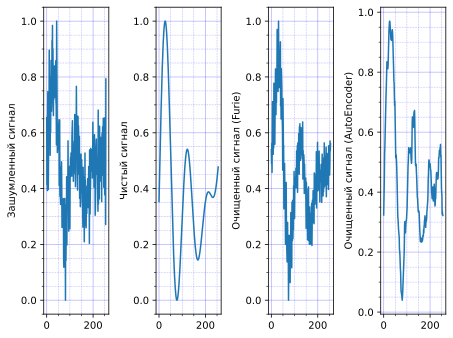

In [ ]:

      



print('R2 error furie: {0}\n'.format(r2_score(pure_sample, restore_sample)))
print('R2 error encoder: {0}\n'.format(r2_score(pure_sample, reconstruction)))
print('MAE error furie: {0}\n'.format(mean_absolute_error(pure_sample, restore_sample)))
print('MAE error encoder: {0}\n'.format(mean_absolute_error(pure_sample, reconstruction)))
print('MSE error furie: {0}\n'.format(mean_squared_error(pure_sample, restore_sample)))
print('MSE error encoder: {0}\n'.format(mean_squared_error(pure_sample, reconstruction)))


fig, axes = plt.subplots(1, 4, dpi=300)
      # Plot sample and reconstruciton
axes[0].plot(noisy_sample)
axes[0].set_ylabel('Зашумленный сигнал', fontsize=10)
axes[1].plot(pure_sample)
axes[1].set_ylabel('Чистый сигнал', fontsize=10)
axes[2].plot(restore_sample)
axes[2].set_ylabel('Очищенный сигнал (Furie)', fontsize=10)
axes[3].plot(reconstruction)
axes[3].set_ylabel('Очищенный сигнал (AutoEncoder)', fontsize=10)
axes[0].xaxis.set_minor_locator(AutoMinorLocator())
axes[0].yaxis.set_minor_locator(AutoMinorLocator())
axes[0].grid(which='major', color='blue', linewidth=0.75, alpha=0.3)
axes[0].grid(which='minor', linestyle='--', color='blue', linewidth=0.5, alpha=0.3)
axes[1].xaxis.set_minor_locator(AutoMinorLocator())
axes[1].yaxis.set_minor_locator(AutoMinorLocator())
axes[1].grid(which='major', color='blue', linewidth=0.75, alpha=0.3)
axes[1].grid(which='minor', linestyle='--', color='blue', linewidth=0.5, alpha=0.3)
axes[2].xaxis.set_minor_locator(AutoMinorLocator())
axes[2].yaxis.set_minor_locator(AutoMinorLocator())
axes[2].grid(which='major', color='blue', linewidth=0.75, alpha=0.3)
axes[2].grid(which='minor', linestyle='--', color='blue', linewidth=0.5, alpha=0.3)
axes[3].xaxis.set_minor_locator(AutoMinorLocator())
axes[3].yaxis.set_minor_locator(AutoMinorLocator())
axes[3].grid(which='major', color='blue', linewidth=0.75, alpha=0.3)
axes[3].grid(which='minor', linestyle='--', color='blue', linewidth=0.5, alpha=0.3)
plt.tight_layout()